# FastPitch SpeakerAdaptation

This notebook is designed to provide a guide on how to run FastPitch Speaker Adaptation Pipeline. It contains the following sections:
1. **Pre-train Multi-Speaker FastPitch**: pre-train a multi-speaker FastPitch
2. **Fine-tune HiFiGAN**: fine-tune a vocoder for the pre-trained multi-speaker FastPitch
3. **Fine-tune FastPitch**: fine-tune pre-trained multi-speaker FastPitch for a new speaker
4. **Inference**: generate speech from adpated FastPitch
5. **Evaluation**: evaluate objective metrics including Pitch/Duration MSE, SECS, and CFSD

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [2]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode pynini==2.1.4 scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [73]:
codedir = 'NeMoTTS'
datadir = 'NeMoTTS_dataset'
normdir = 'NeMoTTS_normalize_files'
suppdir = "NeMoTTS_sup_data"
confdir = "NeMoTTS_conf"
logsdir = "NeMoTTS_logs"
melsdir = "NeMoTTS_mels"
gensdir = "NeMoTTS_gens"
evaldir = "NeMoTTS_eval"

In [ ]:
!wandb login #paste_wandb_apikey_here

In [49]:
import os
import json
import nemo
import torch
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

# 1. Pre-train Multi-Speaker FastPitch

## a. Dataset Preparation

In [31]:
!mkdir {codedir} && cd {codedir} && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/libritts/get_data.py

--2022-09-03 15:48:02--  https://raw.githubusercontent.com/nvidia/NeMo/main/scripts/dataset_processing/tts/libritts/get_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4945 (4.8K) [text/plain]
Saving to: ‘get_data.py’

get_data.py         100%[===================>]   4.83K  --.-KB/s    in 0s      

2022-09-03 15:48:02 (52.6 MB/s) - ‘get_data.py’ saved [4945/4945]



In [45]:
!(mkdir {datadir} && \
  cd {codedir} && \
  python get_data.py \
        --data-root ../{datadir}/ \
        --data-sets 'dev_clean' \
        --val-size 512 \
        --spk-size 100)

100%|██████████████████████████████████████| 5736/5736 [00:08<00:00, 646.02it/s]


In [151]:
!ls {datadir}/LibriTTS/dev-clean-manifest

pitch_stats.json  train_manifest_hifigan.json  val_manifest_hifigan.json
speaker.json	  train_manifest.json	       val_manifest.json


## b. Preprocessing

In [21]:
from nemo.collections.tts.torch.g2ps import EnglishG2p
from nemo.collections.tts.torch.data import TTSDataset
from nemo_text_processing.text_normalization.normalize import Normalizer
from nemo.collections.tts.torch.tts_tokenizers import EnglishPhonemesTokenizer, EnglishCharsTokenizer

[NeMo W 2022-09-03 15:37:25 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-09-03 15:37:26 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-09-03 15:37:26 experimental:27] Module <class 'nemo.collections.tts.torch.g2ps.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [39]:
# additional files
!mkdir -p {normdir} && cd {normdir} \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv

--2022-09-03 15:52:30--  https://raw.githubusercontent.com/nvidia/NeMo/main/scripts/tts_dataset_files/cmudict-0.7b_nv22.08
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3741500 (3.6M) [text/plain]
Saving to: ‘cmudict-0.7b_nv22.08’

cmudict-0.7b_nv22.0 100%[===================>]   3.57M  --.-KB/s    in 0.05s   

2022-09-03 15:52:30 (78.8 MB/s) - ‘cmudict-0.7b_nv22.08’ saved [3741500/3741500]

--2022-09-03 15:52:30--  https://raw.githubusercontent.com/nvidia/NeMo/main/scripts/tts_dataset_files/heteronyms-052722
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaitin

In [41]:
# Text normalizer
text_normalizer = Normalizer(
    lang="en", 
    input_case="cased", 
    whitelist=f"{normdir}/lj_speech.tsv"
)

text_normalizer_call_kwargs = {
    "punct_pre_process": True,
    "punct_post_process": True
}

# Text tokenizer
# Grapheme-to-phoneme module
g2p = EnglishG2p(
    phoneme_dict=f"{normdir}/cmudict-0.7b_nv22.08",
    heteronyms=f"{normdir}/heteronyms-052722"
)

# Text tokenizer
text_tokenizer = EnglishPhonemesTokenizer(
    punct=True,
    stresses=True,
    chars=True,
    apostrophe=True,
    pad_with_space=True,
    g2p=g2p,
)

[NeMo I 2022-09-03 15:53:30 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-09-03 15:53:55 g2ps:86] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [51]:
def pre_calculate_supplementary_data(manifest_dir, sup_data_path, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs, 
                                     batch_size=32, sample_rate=22050):
    # init train and val dataloaders
    stages = ["train", "val"]
    stage2dl = {}
    for stage in stages:
        ds = TTSDataset(
            manifest_filepath=os.path.join(manifest_dir, f"{stage}_manifest.json"),
            sample_rate=sample_rate,
            sup_data_path=sup_data_path,
            sup_data_types=sup_data_types,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            window="hann",
            n_mels=80,
            lowfreq=0,
            highfreq=8000,
            text_tokenizer=text_tokenizer,
            text_normalizer=text_normalizer,
            text_normalizer_call_kwargs=text_normalizer_call_kwargs

        ) 
        stage2dl[stage] = torch.utils.data.DataLoader(ds, batch_size=batch_size, collate_fn=ds._collate_fn, num_workers=12, pin_memory=True)
    
    # iteration over dataloaders
    pitch_mean, pitch_std, pitch_min, pitch_max = None, None, None, None
    for stage, dl in stage2dl.items():
        pitch_list = []
        for batch in tqdm(dl, total=len(dl)):
            tokens, tokens_lengths, audios, audio_lengths, attn_prior, pitches, pitches_lengths = batch
            pitch_list.append(pitches[pitches != 0])
            
        if stage == "train":
            pitch_tensor = torch.cat(pitch_list)
            pitch_mean, pitch_std = pitch_tensor.mean().item(), pitch_tensor.std().item()
            pitch_min, pitch_max = pitch_tensor.min().item(), pitch_tensor.max().item()
            
    return pitch_mean, pitch_std, pitch_min, pitch_max

In [54]:
sup_data_types = ["align_prior_matrix", "pitch"]
manifest_dir = f'{datadir}/LibriTTS/dev-clean-manifest'
pitch_mean, pitch_std, pitch_min, pitch_max = pre_calculate_supplementary_data(
    manifest_dir, suppdir, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs
)

[NeMo I 2022-09-03 16:08:03 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/dev-clean-manifest/train_manifest.json.


5224it [02:08, 40.67it/s]

[NeMo I 2022-09-03 16:10:12 data:221] Loaded dataset with 5224 files.
[NeMo I 2022-09-03 16:10:12 data:223] Dataset contains 8.17 hours.
[NeMo I 2022-09-03 16:10:12 data:321] Pruned 0 files. Final dataset contains 5224 files
[NeMo I 2022-09-03 16:10:12 data:323] Pruned 0.00 hours. Final dataset contains 8.17 hours.


[NeMo I 2022-09-03 16:10:12 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/dev-clean-manifest/val_manifest.json.


512it [00:12, 39.59it/s]

[NeMo I 2022-09-03 16:10:25 data:221] Loaded dataset with 512 files.
[NeMo I 2022-09-03 16:10:25 data:223] Dataset contains 0.80 hours.
[NeMo I 2022-09-03 16:10:25 data:321] Pruned 0 files. Final dataset contains 512 files
[NeMo I 2022-09-03 16:10:25 data:323] Pruned 0.00 hours. Final dataset contains 0.80 hours.


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [56]:
with open(os.path.join(manifest_dir, 'pitch_stats.json'), 'w') as f:
    json.dump({'pitch':[pitch_mean, pitch_std, pitch_min, pitch_max]}, f)

## c. Training

In [59]:
!mkdir -p {confdir} && cd {confdir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml

--2022-09-03 17:15:29--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6716 (6.6K) [text/plain]
Saving to: ‘fastpitch_align_v1.05.yaml’

fastpitch_align_v1. 100%[===================>]   6.56K  --.-KB/s    in 0s      

2022-09-03 17:15:29 (60.0 MB/s) - ‘fastpitch_align_v1.05.yaml’ saved [6716/6716]



In [60]:
!cd {codedir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/fastpitch.py

--2022-09-03 17:16:09--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/fastpitch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1365 (1.3K) [text/plain]
Saving to: ‘fastpitch.py’

fastpitch.py        100%[===================>]   1.33K  --.-KB/s    in 0s      

2022-09-03 17:16:09 (62.1 MB/s) - ‘fastpitch.py’ saved [1365/1365]



In [302]:
!(python {codedir}/fastpitch.py --config-path={os.path.abspath(confdir)} --config-name=fastpitch_align_v1.05.yaml \
  sample_rate=22050 \
  train_dataset={manifest_dir}/train_manifest.json \
  validation_datasets={manifest_dir}/val_manifest.json \
  sup_data_types="['align_prior_matrix', 'pitch', 'speaker_id']" \
  sup_data_path={suppdir} \
  +init_from_pretrained_model=tts_en_fastpitch \
  pitch_mean={pitch_mean} \
  pitch_std={pitch_std} \
  pitch_fmin={pitch_min} \
  pitch_fmax={pitch_max} \
  model.n_speakers=100 \
  model.use_lookup_speaker=True \
  model.use_gst_speaker=True \
  model.input_fft.use_cat_speaker=True \
  model.output_fft.use_cat_speaker=True \
  model.duration_predictor.use_cat_speaker=True \
  model.pitch_predictor.use_cat_speaker=True \
  model.alignment_module.use_cat_speaker=True \
  model.input_fft.use_cln_speaker=True \
  model.output_fft.use_cln_speaker=True \
  model.duration_predictor.use_cln_speaker=True \
  model.pitch_predictor.use_cln_speaker=True \
  phoneme_dict_path={normdir}/cmudict-0.7b_nv22.08 \
  heteronyms_path={normdir}/heteronyms-052722 \
  whitelist_path={normdir}/lj_speech.tsv \
  model.train_ds.dataloader_params.batch_size=8 \
  model.validation_ds.dataloader_params.batch_size=8 \
  model.train_ds.dataloader_params.num_workers=8 \
  model.validation_ds.dataloader_params.num_workers=8 \
  model.train_ds.dataset.max_duration=20 \
  model.validation_ds.dataset.max_duration=20 \
  model.validation_ds.dataset.min_duration=0.1 \
  ~model.train_ds.dataset.use_beta_binomial_interpolator \
  ~model.validation_ds.dataset.use_beta_binomial_interpolator \
  +model.text_tokenizer.add_blank_at=True \
  exp_manager.exp_dir={logsdir} \
  +exp_manager.create_wandb_logger=True \
  +exp_manager.wandb_logger_kwargs.name="tutorial" \
  +exp_manager.wandb_logger_kwargs.project="NeMo" \
  trainer.check_val_every_n_epoch=1 \
  trainer.log_every_n_steps=1 \
  trainer.max_epochs=500 \
  trainer.devices=1 \
  trainer.strategy=ddp \
  trainer.precision=32 \
)

[NeMo W 2022-09-05 18:25:47 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-09-05 18:25:49 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-09-05 18:25:49 exp_manager:287] Experiments will be logged at NeMoTTS_logs/FastPitch/2022-09-05_18-25-49
[NeMo I 2022-09-05 18:25:49 exp_manager:661] TensorboardLogger has been set up
wandb: Currently logged in as: chengping. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.19
wandb: Run data is saved locally in NeMoTTS_logs/wandb/run-20220905_182550-2022-09-05_18-25-

# 2. Fine-tune HiFiGAN

## a. Dataset Preparation

In [309]:
from nemo.collections.asr.parts.preprocessing.features import WaveformFeaturizer
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.torch.helpers import get_base_dir
from matplotlib import pyplot as plt
import random

In [304]:
def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)
            
def plot_spectrogram(spectrogram):
    plt.imshow(spectrogram, origin="lower", aspect="auto")
    plt.show()
    
def gen_spectrogram(record):
    audio_file = record["audio_filepath"]
    save_path = save_dir / audio_file.split("/")[-1].replace(".wav", ".npy")
    if os.path.exists(save_path):
        return save_path
    
    if "normalized_text" in record:
        text = spec_model.parse(record["normalized_text"], normalize=False)
    else:
        text = spec_model.parse(record['text'])
        
    text_id = str(Path(record['audio_filepath']).relative_to(base_data_dir).with_suffix("")).replace("/", "_")
    speaker = torch.tensor([record['speaker']]).to(spec_model.device)
    
    audio = wave_model.process(audio_file, trim=False)
    audio_len = torch.tensor(audio.shape[0]).long()
    audio = audio.unsqueeze(0).to(device=spec_model.device)
    audio_len = audio_len.unsqueeze(0).to(device=spec_model.device)
    
    
    ref_pool = speaker_to_index[record["speaker"]] - set([i]) if len(speaker_to_index[record["speaker"]]) > 1 else speaker_to_index[record["speaker"]]
    ref_sample = train_manifest[random.sample(ref_pool, 1)[0]]
    ref_audio = wave_model.process(ref_sample["audio_filepath"], trim=False)
    ref_audio_len = torch.tensor(ref_audio.shape[0]).long()
    ref_audio = ref_audio.unsqueeze(0).to(device=spec_model.device)
    ref_audio_len = ref_audio_len.unsqueeze(0).to(device=spec_model.device)
    
    
    text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=spec_model.device).unsqueeze(0)
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len) 
    ref_spect, ref_spect_len = spec_model.preprocessor(input_signal=ref_audio, length=ref_audio_len)
    attn_prior = torch.load(os.path.join(f"{suppdir}/align_prior_matrix", f"{text_id}.pt")).unsqueeze(0).to(spec_model.device)     
    
    with torch.no_grad():
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
          ref_spec=ref_spect, 
          ref_spec_lens=ref_spect_len,
        )[0]
        
    np.save(save_path, spectrogram[0].to('cpu').numpy())
    return save_path

In [305]:
manifest_dir = f'{datadir}/LibriTTS/dev-clean-manifest'
train_manifest = list(json_reader(os.path.join(manifest_dir, 'train_manifest.json')))
val_manifest = list(json_reader(os.path.join(manifest_dir, 'val_manifest.json')))

base_data_dir = get_base_dir([item["audio_filepath"] for item in train_manifest])
save_dir = Path(melsdir)
save_dir.mkdir(exist_ok=True, parents=True)

In [306]:
speaker_to_index = defaultdict(list)
for i, d in enumerate(train_manifest): speaker_to_index[d.get('speaker', None)].append(i)
speaker_to_index = {k: set(v) for k, v in speaker_to_index.items()}

In [307]:
last_ckpt = 'NeMoTTS_logs/FastPitch/2022-09-05_18-25-49/checkpoints/FastPitch--v_loss=28.0222-epoch=0.ckpt'

In [ ]:
spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()
wave_model = WaveformFeaturizer(sample_rate=22050)

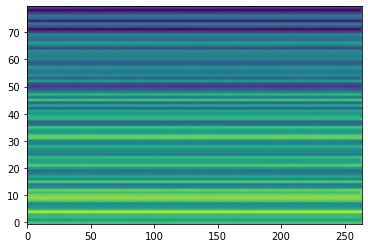

In [118]:
plot_spectrogram(np.load(gen_spectrogram(train_manifest[0])))

In [122]:
for record in tqdm(train_manifest):
    record['mel_filepath'] = str(gen_spectrogram(record))

  0%|          | 0/5224 [00:00<?, ?it/s]

In [123]:
for record in tqdm(val_manifest):
    record['mel_filepath'] = str(gen_spectrogram(record))

  0%|          | 0/512 [00:00<?, ?it/s]

In [128]:
with open(os.path.join(manifest_dir, 'train_manifest_hifigan.json'), "w") as f:
    for r in train_manifest:
        f.write(json.dumps(r) + '\n')
with open(os.path.join(manifest_dir, 'val_manifest_hifigan.json'), "w") as f:
    for r in val_manifest:
        f.write(json.dumps(r) + '\n')

## b. Training

In [142]:
!cd {confdir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml
!cd {confdir} \
&& mkdir -p model/train_ds && cd model/train_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml 
!cd {confdir} \
&& mkdir -p model/validation_ds && cd model/validation_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/validation_ds/val_ds_finetune.yaml
!cd {confdir} \
&& mkdir -p model/generator && cd model/generator && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/generator/v1.yaml
!cd {codedir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/hifigan_finetune.py

--2022-09-03 18:16:54--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/hifigan/hifigan.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2244 (2.2K) [text/plain]
Saving to: ‘hifigan.yaml.1’

hifigan.yaml.1      100%[===================>]   2.19K  --.-KB/s    in 0s      

2022-09-03 18:16:54 (63.9 MB/s) - ‘hifigan.yaml.1’ saved [2244/2244]

--2022-09-03 18:16:54--  https://raw.githubusercontent.com/nvidia/NeMo/main/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [143]:
!(python {codedir}/hifigan_finetune.py --config-path={os.path.abspath(confdir)} --config-name=hifigan.yaml \
train_dataset={manifest_dir}/train_manifest_hifigan.json \
validation_datasets={manifest_dir}/val_manifest_hifigan.json \
+init_from_pretrained_model='tts_hifigan' \
model.train_ds.dataloader_params.batch_size=64 \
model.max_steps=312500 \
model.optim.lr=0.0001 \
trainer.check_val_every_n_epoch=20 \
model/train_ds=train_ds_finetune \
model/validation_ds=val_ds_finetune \
trainer.devices=1 \
trainer.strategy='ddp' \
trainer.precision=16 \
exp_manager.exp_dir={logsdir} \
exp_manager.create_wandb_logger=True \
exp_manager.wandb_logger_kwargs.name="tutorial-HiFiGAN" \
exp_manager.wandb_logger_kwargs.project="NeMo" \
)

[NeMo W 2022-09-03 18:17:07 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-09-03 18:17:07 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-09-03 18:17:07 nemo_logging:349] /home/chsieh/miniconda3/envs/nemo/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'hifigan.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
      warnings.warn(msg, UserWarning)
    
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-09-03 18:17:07 exp_manager:287] Experiments will be logged at NeMoTTS_logs/HifiGan/2022-09-03_18-17-07
[NeMo I 2022

# 3. Fine-tune FastPitch

## a. Data Preparation

In [153]:
!(cd {codedir} && python get_data.py \
        --data-root ../{datadir}/ \
        --data-sets 'test_clean' \
        --train-min-size 15 \
        --val-size 20 \
        --spk-size 10 \
        --balance-gender \
        --separate-speaker \
)

100%|██████████████████████████████████████| 4837/4837 [00:11<00:00, 419.63it/s]
get_data.py:114: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(str(args.data_root / 'LibriTTS'/ 'speakers.tsv'), sep='\t', index_col=False)


In [154]:
!ls {manifest_dir}

1089  2300  237  260  3570  4446  5683	7127  8230  8555


In [2]:
speaker_ids = [1089, 2300, 237, 260, 3570, 4446, 5683, 7127, 8230, 8555]

## b. Preprocessing

In [192]:
for speaker_id in speaker_ids:
    manifest_dir = f'{datadir}/LibriTTS/test-clean-manifest/{speaker_id}'
    sup_data_types = ["align_prior_matrix", "pitch"]
    pitch_mean, pitch_std, pitch_min, pitch_max = pre_calculate_supplementary_data(
        manifest_dir, suppdir, sup_data_types, text_tokenizer, text_normalizer, text_normalizer_call_kwargs
    )
    with open(os.path.join(manifest_dir, 'pitch_stats.json'), 'w') as f:
        json.dump({'pitch':[pitch_mean, pitch_std, pitch_min, pitch_max]}, f)

[NeMo I 2022-09-05 15:24:27 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/1089/train_manifest.json.


74it [00:04, 15.21it/s]

[NeMo I 2022-09-05 15:24:32 data:221] Loaded dataset with 74 files.
[NeMo I 2022-09-05 15:24:32 data:223] Dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:24:32 data:321] Pruned 0 files. Final dataset contains 74 files
[NeMo I 2022-09-05 15:24:32 data:323] Pruned 0.00 hours. Final dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:24:32 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/1089/val_manifest.json.



20it [00:00, 20.90it/s]

[NeMo I 2022-09-05 15:24:33 data:221] Loaded dataset with 20 files.
[NeMo I 2022-09-05 15:24:33 data:223] Dataset contains 0.05 hours.
[NeMo I 2022-09-05 15:24:33 data:321] Pruned 0 files. Final dataset contains 20 files
[NeMo I 2022-09-05 15:24:33 data:323] Pruned 0.00 hours. Final dataset contains 0.05 hours.



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.09s/it]

[NeMo I 2022-09-05 15:31:30 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/2300/train_manifest.json.



59it [00:04, 11.96it/s]

[NeMo I 2022-09-05 15:31:35 data:221] Loaded dataset with 59 files.
[NeMo I 2022-09-05 15:31:35 data:223] Dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:31:35 data:321] Pruned 0 files. Final dataset contains 59 files
[NeMo I 2022-09-05 15:31:35 data:323] Pruned 0.00 hours. Final dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:31:35 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/2300/val_manifest.json.



20it [00:01, 17.04it/s]

[NeMo I 2022-09-05 15:31:36 data:221] Loaded dataset with 20 files.
[NeMo I 2022-09-05 15:31:36 data:223] Dataset contains 0.06 hours.
[NeMo I 2022-09-05 15:31:36 data:321] Pruned 0 files. Final dataset contains 20 files
[NeMo I 2022-09-05 15:31:36 data:323] Pruned 0.00 hours. Final dataset contains 0.06 hours.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.48s/it]

[NeMo I 2022-09-05 15:39:11 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/237/train_manifest.json.



104it [00:05, 18.96it/s]

[NeMo I 2022-09-05 15:39:17 data:221] Loaded dataset with 104 files.
[NeMo I 2022-09-05 15:39:17 data:223] Dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:39:17 data:321] Pruned 0 files. Final dataset contains 104 files
[NeMo I 2022-09-05 15:39:17 data:323] Pruned 0.00 hours. Final dataset contains 0.25 hours.
[NeMo I 2022-09-05 15:39:17 data:186] Loading dataset from NeMoTTS_dataset/LibriTTS/test-clean-manifest/237/val_manifest.json.



20it [00:00, 37.16it/s]

[NeMo I 2022-09-05 15:39:17 data:221] Loaded dataset with 20 files.
[NeMo I 2022-09-05 15:39:17 data:223] Dataset contains 0.02 hours.
[NeMo I 2022-09-05 15:39:17 data:321] Pruned 0 files. Final dataset contains 20 files
[NeMo I 2022-09-05 15:39:17 data:323] Pruned 0.00 hours. Final dataset contains 0.02 hours.



  0%|                                                                                                                                                                                                                                                                                           | 0/4 [00:44<?, ?it/s]


KeyboardInterrupt: 

## c. Training

In [ ]:
!cd {codedir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/fastpitch_finetune_multispeaker.py

In [20]:
speaker_ids = [260, 1089]

In [74]:
for speaker_id in speaker_ids:
    manifest_dir = f'{datadir}/LibriTTS/test-clean-manifest/{speaker_id}'
    save_version = f'LibriTTS-speaker-{speaker_id}-test'
    !(echo {manifest_dir})
    mean=!(cat {manifest_dir}/pitch_stats.json | jq -r ".pitch[0]")
    std=!(cat {manifest_dir}/pitch_stats.json  | jq -r ".pitch[1]")
    fmin=!(cat {manifest_dir}/pitch_stats.json | jq -r ".pitch[2]")
    fmax=!(cat {manifest_dir}/pitch_stats.json | jq -r ".pitch[3]")
    !(python {codedir}/fastpitch_finetune_multispeaker.py --config-path={os.path.abspath(confdir)} --config-name=fastpitch_align_v1.05.yaml \
    sample_rate=22050 \
    train_dataset={manifest_dir}/train_manifest.json \
    validation_datasets={manifest_dir}/val_manifest.json \
    sup_data_types="['align_prior_matrix', 'pitch', 'speaker_id']" \
    sup_data_path={suppdir} \
    +init_from_ptl_ckpt="/home/chsieh/FastPitch-gst-pretrain-sp1151.ckpt" \
    pitch_mean={mean[0]} \
    pitch_std={std[0]} \
    pitch_fmin={fmin[0]} \
    pitch_fmax={fmax[0]} \
    finetune_multispeaker.freeze_all=True \
    finetune_multispeaker.add_random_speaker=False \
    finetune_multispeaker.add_weight_speaker=True \
    finetune_multispeaker.add_cln=False \
    finetune_multispeaker.add_adapter=True \
    finetune_multispeaker.add_lora=False \
    finetune_multispeaker.add_prefix=False \
    finetune_multispeaker.add_bitfit=False \
    model.n_speakers=100 \
    model.use_lookup_speaker=True \
    model.use_gst_speaker=True \
    model.input_fft.use_cat_speaker=True \
    model.output_fft.use_cat_speaker=True \
    model.duration_predictor.use_cat_speaker=True \
    model.pitch_predictor.use_cat_speaker=True \
    model.alignment_module.use_cat_speaker=True \
    model.input_fft.use_cln_speaker=True \
    model.output_fft.use_cln_speaker=True \
    model.duration_predictor.use_cln_speaker=True \
    model.pitch_predictor.use_cln_speaker=True \
    phoneme_dict_path={normdir}/cmudict-0.7b_nv22.08 \
    heteronyms_path={normdir}/heteronyms-052722 \
    whitelist_path={normdir}/lj_speech.tsv \
    model.train_ds.dataloader_params.batch_size=8 \
    model.validation_ds.dataloader_params.batch_size=8 \
    model.train_ds.dataloader_params.num_workers=8 \
    model.validation_ds.dataloader_params.num_workers=8 \
    ~model.train_ds.dataset.use_beta_binomial_interpolator \
    ~model.validation_ds.dataset.use_beta_binomial_interpolator \
    model.optim.lr=2e-4 \
    ~model.optim.sched \
    model.optim.name=adam \
    model.optim.weight_decay=0.0 \
    +model.text_tokenizer.add_blank_at=True \
    trainer.check_val_every_n_epoch=100 \
    trainer.max_epochs=100 \
    trainer.log_every_n_steps=1 \
    trainer.devices=1 \
    trainer.strategy=ddp \
    trainer.precision=32 \
    exp_manager.exp_dir={logsdir} \
    +exp_manager.create_wandb_logger=True \
    +exp_manager.version={save_version} \
    +exp_manager.wandb_logger_kwargs.name="tutorial-finetune" \
    +exp_manager.wandb_logger_kwargs.project="NeMo" \
    +exp_manager.checkpoint_callback_params.save_top_k=-1 \
    )

NeMoTTS_dataset/LibriTTS/test-clean-manifest/260
[NeMo W 2022-09-14 11:05:48 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-09-14 11:05:49 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-09-14 11:05:50 exp_manager:287] Experiments will be logged at NeMoTTS_logs/FastPitch/LibriTTS-speaker-260-test
[NeMo I 2022-09-14 11:05:50 exp_manager:661] TensorboardLogger has been set up
wandb: Currently logged in as: chengping. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.19
wandb: Run data is saved locally in N

# 4. Inference

In [75]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.torch.helpers import get_base_dir
from nemo.collections.tts.modules.speaker_modules import Weighted_SpeakerEmbedding
from nemo.collections.asr.parts.preprocessing.features import WaveformFeaturizer
from nemo.collections.common.parts import adapter_modules
from matplotlib import pyplot as plt
import IPython.display as ipd
import pickle
import fnmatch

In [76]:
def gt_spectrogram(wave_model, spec_gen_model, audio_path):
    features = wave_model.process(audio_path, trim=False)
    audio, audio_length = features, torch.tensor(features.shape[0]).long()
    audio = audio.unsqueeze(0).to(device=spec_gen_model.device)
    audio_length = audio_length.unsqueeze(0).to(device=spec_gen_model.device)
    with torch.no_grad():
        spectrogram, spec_len = spec_gen_model.preprocessor(input_signal=audio, length=audio_length)
    return spectrogram, spec_len

def gen_spectrogram(spec_gen_model, str_input, speaker, ref_spec, ref_spec_len):
    parsed = spec_gen_model.parse(str_input)
    speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
    with torch.no_grad():    
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker, ref_spec=ref_spec, ref_spec_lens=ref_spec_len)
    return spectrogram
  
    
def sync_audio(vocoder_model, spectrogram):    
    with torch.no_grad():  
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return audio


def mse_metrics(spec_gen_model, file_id, str_input, speaker, spec_ref, spec_ref_lens, spec_tgt, spec_tgt_lens, pitch_mean, pitch_std):
    text = spec_gen_model.parse(str_input)
    text_lens = torch.tensor(text.shape[1]).long().unsqueeze(0).to(device=spec_gen_model.device)
    speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)

    pitch = torch.load(os.path.join(f"{suppdir}/pitch", f"{file_id}.pt")).to(spec_gen_model.device)

    pitch -= pitch_mean
    pitch[pitch == -pitch_mean] = 0.0
    pitch /= pitch_std
    pitch = pitch.unsqueeze(0)

    attn_prior = torch.load(os.path.join(f"{suppdir}/align_prior_matrix", f"{file_id}.pt")).to(spec_gen_model.device) 
    attn_prior = attn_prior.unsqueeze(0)
    
    with torch.no_grad():    
        _, _, _, log_durs_pred, pitch_pred, _, _, _, durs, pitch = spec_gen_model(
            text=text,
            durs=None,
            pitch=pitch,
            speaker=speaker,
            pace=1.0,
            spec=spec_tgt,
            ref_spec=spec_ref,
            ref_spec_lens=spec_ref_lens,
            attn_prior=attn_prior,
            mel_lens=spec_tgt_lens,
            input_lens=text_lens
        )
        pitch_loss = spec_gen_model.pitch_loss(pitch_predicted=pitch_pred, pitch_tgt=pitch, len=text_lens)
        dur_loss = spec_gen_model.duration_loss(log_durs_predicted=log_durs_pred, durs_tgt=durs, len=text_lens)

        
    return pitch_loss.item(), dur_loss.item()

In [77]:
os.makedirs(gensdir, exist_ok=True)
sample_rate = 22050
wave_model = WaveformFeaturizer(sample_rate=sample_rate)
vocoder_model = HifiGanModel.load_from_checkpoint(checkpoint_path='/home/chsieh/HifiGan-finetune-sp1151.ckpt')
vocoder_model = vocoder_model.eval().cuda()

[NeMo W 2022-09-14 11:07:21 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /ws/mel-dataset/Libritts-FP-emb-catclngst-mels-22k-1151/hifigan_train_1151.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
      pin_memory: true
    
[NeMo W 2022-09-14 11:07:21 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _tar

[NeMo I 2022-09-14 11:07:21 features:216] PADDING: 0
[NeMo I 2022-09-14 11:07:21 features:224] STFT using exact pad
[NeMo I 2022-09-14 11:07:21 features:216] PADDING: 0
[NeMo I 2022-09-14 11:07:21 features:224] STFT using exact pad


In [79]:
ckpts = {}
for speaker_id in [260]:
    path = f'{logsdir}/FastPitch/LibriTTS-speaker-{speaker_id}-test/checkpoints'
    ckpt = sorted(os.listdir(path))[0]
    ckpts[f"{speaker_id}"] =  os.path.join(path, ckpt)

In [80]:
total_pitch_mse = []
total_dur_mse   = []

  0%|                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-09-14 11:08:12 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-09-14 11:08:42 g2ps:86] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-09-14 11:08:42 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: NeMoTTS_dataset/LibriTTS/test-clean-manifest/260/train_manifest.json
      sample_rate: 22050
      sup_data_path: NeMoTTS_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      - speaker_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_dura

[NeMo I 2022-09-14 11:08:42 features:216] PADDING: 1


[NeMo W 2022-09-14 11:08:43 nemo_logging:349] /home/chsieh/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:213: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['fastpitch.speaker_emb.weight']
      rank_zero_warn(
    
[NeMo W 2022-09-14 11:08:43 nemo_logging:349] /home/chsieh/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['aligner.key_proj.0.adapter_layer.adapter.module.0.weight', 'aligner.key_proj.0.adapter_layer.adapter.module.0.bias', 'aligner.key_proj.0.adapter_layer.adapter.module.1.weight', 'aligner.key_proj.0.adapter_layer.adapter.module.3.weight', 'aligner.key_proj.2.adapter_layer.adapter.module.0.weight', 'aligner.key_proj.2.adapter_layer.adapter.module.0.bias', 'aligner.key_proj.2.adapter_layer.adapter.module.1.weight', 'aligner.key_proj.2.adapter_layer.adapter.module.3.weight', 'al

[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating TemporalPredictorAdapter Adapter input dim from 384 to 256
[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating TemporalPredictorAdapter Adapter input dim from 384 to 256
[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating AlignmentEncoderAdapter Adapter input dim from 384 to 768
[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating AlignmentEncoderAdapter Adapter input dim from 768 to 80
[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating AlignmentEncoderAdapter Adapter input dim from 80 to 160
[NeMo I 2022-09-14 11:08:43 adapter_utils:52] Updating AlignmentEncoderAdapter Adapter input dim from 160 to 80
[NeMo I 2022-09-14 11:08:43 adapter_mixins:627] Setting adapter 'adapter' status : Enabled = False
[NeMo I 2022-09-14 11:08:43 adapter_mixins:642] Setting adapter 'adapter' status : Enabled = True
[NeMo I 2022-09-14 11:08:43 adapter_mixins:343] Unfrozen adapter : adapter
Speaker: 260 | Text: Other flashes with incessant p

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.04s/it]


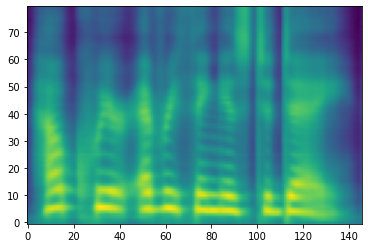

In [81]:
for speaker_id, spec_model_ckpt in tqdm(ckpts.items()):
    
    gensdir_user = os.path.join(gensdir, speaker_id)
    os.makedirs(gensdir_user, exist_ok=True)
    
    spec_model = FastPitchModel.load_from_checkpoint(spec_model_ckpt, strict=False)
    state_dict = torch.load(spec_model_ckpt)['state_dict']
    has_adapter = any(['adapter' in k for k in state_dict.keys()])
    has_lora = any(['lora' in k for k in state_dict.keys()])
    has_prefix = any(['prefix' in k for k in state_dict.keys()])
    
    if has_adapter:
        adapter_cfg = adapter_modules.LinearAdapterConfig(
            in_features=spec_model.cfg.output_fft.d_model,  # conformer specific model dim. Every layer emits this dim at its output.
            dim=256,  # the bottleneck dimension of the adapter
            activation='swish',  # activation used in bottleneck block
            norm_position='pre',  # whether to use LayerNorm at the beginning or the end of the adapter
        )
        spec_model.add_adapter(name='encoder+decoder+duration_predictor+pitch_predictor+aligner:adapter', cfg=adapter_cfg)
        spec_model.set_enabled_adapters(enabled=False)
        spec_model.set_enabled_adapters('adapter', enabled=True)
        spec_model.unfreeze_enabled_adapters()
        
    if has_lora:
        lora_cfg = adapter_modules.LoraConfig(
            in_features=spec_model.cfg.output_fft.d_model, 
            out_features=spec_model.cfg.output_fft.n_head * spec_model.cfg.output_fft.d_head,
            r=256, 
            alpha=8,
            dropout=0.9,
        )
        spec_model.add_lora(name='encoder+decoder:lora', cfg=lora_cfg)
        spec_model.set_enabled_loras(enabled=False)
        spec_model.set_enabled_loras('lora', enabled=True)
        spec_model.unfreeze_enabled_loras()
    
    if has_prefix:
        prefix_cfg = adapter_modules.PrefixConfig(
            in_features=spec_model.cfg.output_fft.n_head * spec_model.cfg.output_fft.d_head, 
            dim=256,
            prefix_length=30,
            dropout=0.9,
        )
        spec_model.add_prefix(name='encoder+decoder:prefix', cfg=prefix_cfg)
        spec_model.set_enabled_prefixs(enabled=False)
        spec_model.set_enabled_prefixs('prefix', enabled=True)
        spec_model.unfreeze_enabled_prefixs()        

    spec_model.fastpitch.speaker_emb = Weighted_SpeakerEmbedding(pretrained_embedding=spec_model.fastpitch.speaker_emb)
    spec_model.load_state_dict(state_dict)
    spec_model.eval().cuda()
    
    manifest_dir = f'{datadir}/LibriTTS/test-clean-manifest/{speaker_id}'
    
    num_ref = 5
    ref_records = []
    with open(f"{manifest_dir}/train_manifest.json", "r") as f:
        for i, line in enumerate(f):
            if len(ref_records) >= num_ref:
                break
            ref_records.append(json.loads(line))
    
    num_test = 20
    test_records = []
    with open(f"{manifest_dir}/val_manifest.json", "r") as f:
        for i, line in enumerate(f):
            test_records.append(json.loads(line))
            if len(test_records) >= num_test:
                break
                
    with open(f"{manifest_dir}/pitch_stats.json", "r") as f:
        stats = json.load(f)
        pitch_mean = stats['pitch'][0]
        pitch_std  = stats['pitch'][1]
        
    base_data_dir = get_base_dir([item["audio_filepath"] for item in test_records])  
        
    for i, ref_record in enumerate(ref_records):
        print(f"Speaker: {ref_record['ori_speaker']} | Text: {ref_record['text']}")
        # Write Reference Audio
        audio = ipd.Audio(ref_record['audio_filepath'], rate=sample_rate)
        with open(os.path.join(gensdir_user, f'Ref-{i}.wav'), 'wb') as f: 
            f.write(audio.data)   
        
    for i, test_record in enumerate(test_records):
        print(f"Speaker: {test_record['ori_speaker']} | Text: {test_record['text']}")
        
        # Write Text
        with open(os.path.join(gensdir_user, f'{i}-text.txt'), 'w') as f: 
            f.write(test_record['text'])
            
        # Write Ground Truth Audio
        audio = ipd.Audio(test_record['audio_filepath'], rate=sample_rate)
        with open(os.path.join(gensdir_user, f'{i}-GT.wav'), 'wb') as f: 
            f.write(audio.data)
            
        # Write Ground Truth Spectrogram Audio and Figure
        spec_gt, spec_gt_len = gt_spectrogram(wave_model, spec_model, test_record['audio_filepath'])
        audio = sync_audio(vocoder_model, spec_gt)
        audio = ipd.Audio(audio, rate=sample_rate)
        with open(os.path.join(gensdir_user, f'{i}-GTmel.wav'), 'wb') as f: 
            f.write(audio.data)
            
            
        plt.imshow(spec_gt.to('cpu').numpy()[0], origin="lower", aspect="auto")
        plt.savefig(os.path.join(gensdir_user, f'{i}-GTmel.png'))
        
            
        # Write Generate Audio and Figure
        spec_ref, spec_ref_len = gt_spectrogram(wave_model, spec_model, ref_records[0]['audio_filepath'])
        spec_gen = gen_spectrogram(spec_model, test_record['text'], test_record['speaker'], spec_ref, spec_ref_len)
        audio = sync_audio(vocoder_model, spec_gen)
        audio = ipd.Audio(audio, rate=sample_rate)
        with open(os.path.join(gensdir_user, f'{i}-Gen.wav'), 'wb') as f: 
            f.write(audio.data)
            
        plt.imshow(spec_gen.to('cpu').numpy()[0], origin="lower", aspect="auto")
        plt.savefig(os.path.join(gensdir_user, f'{i}-Gen.png'))      
        
        # Pitch and Duration MSE
        file_id = str(Path(test_record['audio_filepath']).relative_to(base_data_dir).with_suffix("")).replace("/", "_") 
        pitch_loss, dur_loss = mse_metrics(spec_model, file_id, test_record['text'], test_record['speaker'],  spec_ref, spec_ref_len, spec_gt, spec_gt_len, pitch_mean, pitch_std)
        total_pitch_mse.append(pitch_loss)
        total_dur_mse.append(dur_loss)

In [252]:
os.makedirs(evaldir, exist_ok=True)
with open(os.path.join(evaldir,'pitch.pkl'), 'wb') as f:
    pickle.dump(total_pitch_mse, f)
with open(os.path.join(evaldir,'dur.pkl'), 'wb') as f:
    pickle.dump(total_dur_mse, f)

# 5. Evaluation

## a. Pitch and Duration MSE

In [253]:
with open(os.path.join(evaldir,'pitch.pkl'), 'rb') as f:
    total_pitch_mse = pickle.load(f)
with open(os.path.join(evaldir,'dur.pkl'), 'rb') as f:
    total_dur_mse = pickle.load(f)
    
total_pitch_mse_mean = round(np.mean(total_pitch_mse), 4)
total_pitch_mse_std = round(np.std(total_pitch_mse), 4)
total_dur_mse_mean = round(np.mean(total_dur_mse), 4)
total_dur_mse_std = round(np.std(total_dur_mse), 4)

print(f'Pitch MSE: {total_pitch_mse_mean} ± {total_pitch_mse_std}')
print(f'Duration MSE: {total_dur_mse_mean} ± {total_dur_mse_std}')

Pitch MSE: 0.0877 ± 0.0886
Duration MSE: 0.0643 ± 0.0168


## b. Speaker Embedding Cosine Similarity (SECS)

In [232]:
!cd {codedir} \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/speaker_tasks/filelist_to_manifest.py \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/speaker_tasks/recognition/extract_speaker_embeddings.py

--2022-09-05 17:03:19--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/speaker_tasks/filelist_to_manifest.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8782 (8.6K) [text/plain]
Saving to: ‘filelist_to_manifest.py’

filelist_to_manifes 100%[===================>]   8.58K  --.-KB/s    in 0s      

2022-09-05 17:03:19 (59.5 MB/s) - ‘filelist_to_manifest.py’ saved [8782/8782]

--2022-09-05 17:03:19--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/recognition/extract_speaker_embeddings.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP requ

In [254]:
Audio_files = []
for root, dirnames, filenames in os.walk(gensdir):
    for filename in fnmatch.filter(filenames, '*.wav'):
        Audio_files.append(os.path.abspath(os.path.join(root,filename)))

In [255]:
with open(f'{evaldir}/secs_evaluation.scp', 'w') as f:
    for file in Audio_files:
        f.write(file)
        f.write('\n')

In [256]:
!(python {codedir}/filelist_to_manifest.py --filelist {evaldir}/secs_evaluation.scp --id -2 --out {evaldir}/secs_evaluation.json \
&& python {codedir}/extract_speaker_embeddings.py --manifest={evaldir}/secs_evaluation.json --model_path='titanet_large' --embedding_dir={evaldir} \
)

100%|████████████████████████████████████████| 130/130 [00:01<00:00, 124.70it/s]
wrote NeMoTTS_eval/secs_evaluation_manifest.json
100%|██████████████████████████████████████| 130/130 [00:00<00:00, 54125.42it/s]
wrote NeMoTTS_eval/secs_evaluation.json
[NeMo W 2022-09-05 17:18:56 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo I 2022-09-05 17:18:57 cloud:56] Found existing object /home/chsieh/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-09-05 17:18:57 cloud:62] Re-using file from: /home/chsieh/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-09-05 17:18:57 common:789] Instantiating model from pre-trained checkpoint
[NeMo W 2022-09-05 17:18:58 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Tr

In [257]:
with open(os.path.join(evaldir, 'embeddings/secs_evaluation_embeddings.pkl'), 'rb') as f:
    file = pickle.load(f)

In [258]:
speaker_embedding = defaultdict(lambda: defaultdict(list))
for k, v in file.items():
    spk = k.split('@')[1]
    if 'Ref' in k:
        speaker_embedding[spk]['Ref'].append(v)
    if 'GT.wav' in k:
        speaker_embedding[spk]['GT'].append(v)
    if 'GTmel.wav' in k:
        speaker_embedding[spk]['GTmel'].append(v)
    if 'Gen.wav' in k:
        speaker_embedding[spk]['Gen'].append(v)

In [268]:
gt, gtmel, gen = [], [], []

for spk, emb in speaker_embedding.items():
    ref_emb = np.stack(emb['Ref'])
    gt_emb = np.stack(emb['GT'])
    gtmel_emb = np.stack(emb['GTmel'])
    gen_emb = np.stack(emb['Gen'])
    
    gt.append((ref_emb @ gt_emb.transpose(1,0)).mean())
    gtmel.append((ref_emb @ gtmel_emb.transpose(1,0)).mean())
    gen.append((ref_emb @ gen_emb.transpose(1,0)).mean())

In [282]:
print(f'GT SECS: {round(np.mean(gt).item(), 3)} ± {round(np.std(gt).item(), 3)}')
print(f'GTmel SECS: {round(np.mean(gtmel).item(), 3)} ± {round(np.std(gtmel).item(), 3)}')
print(f'Gen SECS: {round(np.mean(gen).item(), 3)} ± {round(np.std(gen).item(), 3)}')

GT SECS: 0.729 ± 0.081
GTmel SECS: 0.44 ± 0.013
Gen SECS: -0.317 ± 0.013


## c. Conditional Frechet Speech Distance (CFSD)

In [283]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from scipy import linalg

In [287]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [289]:
wave_model = WaveformFeaturizer(sample_rate=16000)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.weight', 'project_q.weight', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_q.bias', 'project_hid.bias', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [294]:
def get_activation(filename):
    audio = wave_model.process(filename, trim=False)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # activation = outputs.last_hidden_state.mean(axis=1)
    activation = outputs.extract_features.mean(axis=1).cpu().numpy()
    return activation

def frechet_classifier_distance_from_activations(activations1, activations2):
    mu1, sigma1 = calculate_activation_statistics(activations1)
    mu2, sigma2 = calculate_activation_statistics(activations2)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

def calculate_activation_statistics(act):
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [264]:
gn_files = []
gt_files = []
for root, dirnames, filenames in os.walk(f'{gensdir}'):
    for filename in fnmatch.filter(filenames, '*Gen.wav'):
        gn_files.append(os.path.join(root,filename))
        gt_files.append(gn_files[-1].replace("Gen", "GT"))

In [297]:
gns = []
gts = []
for gn, gt in tqdm(zip(gn_files, gt_files)):
    gns.append(get_activation(gn))
    gts.append(get_activation(gt))

40it [00:10,  3.85it/s]


In [298]:
print(frechet_classifier_distance_from_activations(np.concatenate(gts), np.concatenate(gns)))

923.4989907730557
